In [1]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader

# Set seeds
torch.manual_seed(0)
np.random.seed(0)

In [2]:
titanic_data = pd.read_csv('./data/titanic.csv')
titanic_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
class TitanicDataset(Dataset):
    def __init__(self, data_path, train):

        data_as_csv = pd.read_csv(data_path)

        data_as_csv   = self.clean_dataset(data_as_csv)
        training_data = data_as_csv.sample(frac=0.8)

        if train:
            self.data = training_data
        else:
            self.data = data_as_csv.drop(training_data.index)

        # Reset index
        self.data = self.data.reset_index(drop=True)

        self.normalized_values = {}

        columns_to_normalize   = ['Age', 'SibSp', 'Parch', 'Fare']

        for column in columns_to_normalize:
            self.normalized_values[column] = self.normalize_column(column)

    def __len__(self):
        return len(self.data)

    def clean_dataset(self, df):
        df.dropna(inplace=True)
        return df

    def normalize_column(self, column_name):
        column = self.data[column_name]

        mean = column.mean()
        std  = column.std()

        return (column - mean) / std

    def __getitem__(self, idx):
        elem = self.data.iloc[idx]

        # One hot encoded
        # ------------------------------------

        pclass = elem['Pclass']

        is_first_class  = pclass == 1
        is_second_class = pclass == 2
        is_third_class  = pclass == 3

        is_female = elem['Sex'] == 'female'

        is_embarked_c = elem['Embarked'] == 'c'
        is_embarked_s = elem['Embarked'] == 's'
        is_embarked_q = elem['Embarked'] == 'q'

        # Feature normalization
        # ------------------------------------

        age   = self.normalized_values['Age'][idx]
        sibsp = self.normalized_values['SibSp'][idx]
        parch = self.normalized_values['Parch'][idx]
        fare  = self.normalized_values['Fare'][idx]

        # Target
        # ------------------------------------

        survived = elem['Survived']

        return_tensor = torch.tensor([
            # First class
            is_first_class, is_second_class, is_third_class,
            # Embarked
            is_embarked_c, is_embarked_s, is_embarked_q,
            # Sex
            is_female,
            # Age, SibSp, Parch, Fare
            age, sibsp, parch, fare
        ])

        return return_tensor, torch.tensor([survived])

In [4]:
train_dataset = TitanicDataset('data/titanic.csv', train=True)
test_dataset  = TitanicDataset('data/titanic.csv', train=False)

print(f'Train size: {len(train_dataset)} Test size: {len(test_dataset)}')

Train size: 146 Test size: 37


In [5]:
import torch.nn as nn
import torch.nn.functional as F

class TitanicModel(nn.Module):
    def __init__(self):
        super(TitanicModel, self).__init__()

        self.fc1 = nn.Linear(11, 3)
        self.fc2 = nn.Linear(3, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

In [6]:
def plot_accuracy_array(accuracy_array, label):
    plt.plot(accuracy_array, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

In [7]:
BATCH_SIZE = 16
EPOCHS = 150

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

def evaluate(model, data):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data:
            outputs = model(inputs.float())
            predicted = torch.round(outputs)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

def train_model(model):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    train_accuracies = np.zeros(EPOCHS)
    test_accuracies = np.zeros(EPOCHS)

    for epoch in range(EPOCHS):
        model.train()

        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()

            outputs = model(inputs.float())
            loss = criterion(outputs, labels.float())

            loss.backward()
            optimizer.step()

        train_accuracy = evaluate(model, train_loader)
        test_accuracy = evaluate(model, test_loader)

        train_accuracies[epoch] = train_accuracy
        test_accuracies[epoch] = test_accuracy

        print(f'Epoch: {epoch} Train accuracy: {train_accuracy} Test accuracy: {test_accuracy}')

    plot_accuracy_array(train_accuracies, 'Training accuracy')
    plot_accuracy_array(test_accuracies, 'Validation accuracy')
    plt.legend()
    plt.show()

    return train_accuracies, test_accuracies

Epoch: 0 Train accuracy: 0.6643835616438356 Test accuracy: 0.5405405405405406
Epoch: 1 Train accuracy: 0.6712328767123288 Test accuracy: 0.5405405405405406
Epoch: 2 Train accuracy: 0.678082191780822 Test accuracy: 0.5405405405405406
Epoch: 3 Train accuracy: 0.7123287671232876 Test accuracy: 0.6216216216216216
Epoch: 4 Train accuracy: 0.726027397260274 Test accuracy: 0.6486486486486487
Epoch: 5 Train accuracy: 0.773972602739726 Test accuracy: 0.7297297297297297
Epoch: 6 Train accuracy: 0.773972602739726 Test accuracy: 0.7297297297297297
Epoch: 7 Train accuracy: 0.7671232876712328 Test accuracy: 0.7027027027027027
Epoch: 8 Train accuracy: 0.7808219178082192 Test accuracy: 0.7297297297297297
Epoch: 9 Train accuracy: 0.7876712328767124 Test accuracy: 0.7027027027027027
Epoch: 10 Train accuracy: 0.7876712328767124 Test accuracy: 0.7027027027027027
Epoch: 11 Train accuracy: 0.7808219178082192 Test accuracy: 0.7297297297297297
Epoch: 12 Train accuracy: 0.7876712328767124 Test accuracy: 0.7297

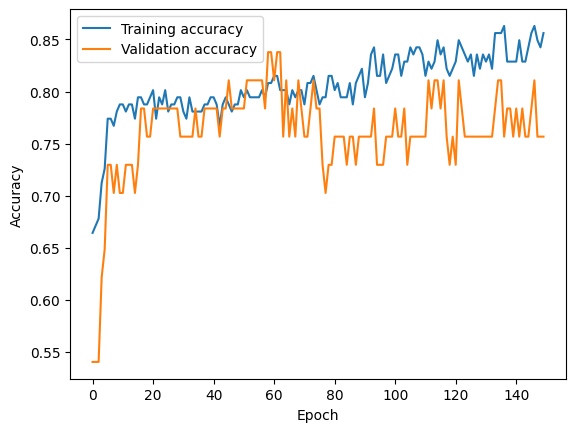

In [8]:
small_model = TitanicModel()
tr1, te1 = train_model(small_model)

In [9]:
class TitanicModelHugeOverfitting(nn.Module):
    def __init__(self):
        super(TitanicModelHugeOverfitting, self).__init__()

        self.fc1 = nn.Linear(11, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))

        return x

Epoch: 0 Train accuracy: 0.7671232876712328 Test accuracy: 0.7297297297297297
Epoch: 1 Train accuracy: 0.7808219178082192 Test accuracy: 0.7297297297297297
Epoch: 2 Train accuracy: 0.7876712328767124 Test accuracy: 0.7297297297297297
Epoch: 3 Train accuracy: 0.773972602739726 Test accuracy: 0.7297297297297297
Epoch: 4 Train accuracy: 0.8013698630136986 Test accuracy: 0.7567567567567568
Epoch: 5 Train accuracy: 0.7945205479452054 Test accuracy: 0.7567567567567568
Epoch: 6 Train accuracy: 0.7945205479452054 Test accuracy: 0.7567567567567568
Epoch: 7 Train accuracy: 0.815068493150685 Test accuracy: 0.7837837837837838
Epoch: 8 Train accuracy: 0.8287671232876712 Test accuracy: 0.8378378378378378
Epoch: 9 Train accuracy: 0.815068493150685 Test accuracy: 0.8108108108108109
Epoch: 10 Train accuracy: 0.815068493150685 Test accuracy: 0.7837837837837838
Epoch: 11 Train accuracy: 0.821917808219178 Test accuracy: 0.8378378378378378
Epoch: 12 Train accuracy: 0.8424657534246576 Test accuracy: 0.83783

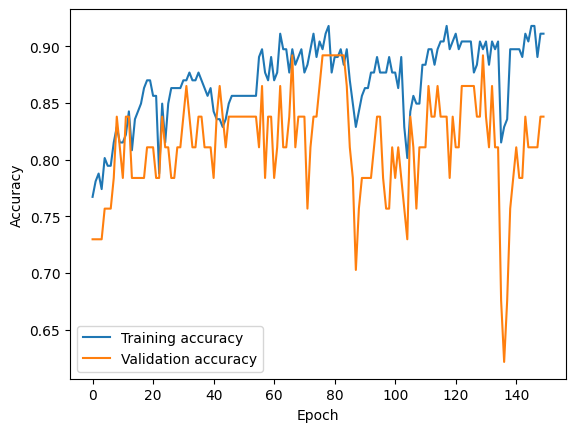

In [10]:
overfitting_model = TitanicModelHugeOverfitting()
tr2, te2 = train_model(overfitting_model)

In [14]:
class TitanicModelHugeOverfittingDropout(nn.Module):
    def __init__(self):
        super(TitanicModelHugeOverfittingDropout, self).__init__()
        self.fc1 = nn.Linear(11, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)

        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))

        x = self.dropout(x)

        x = torch.sigmoid(self.fc4(x))

        return x

Epoch: 0 Train accuracy: 0.7602739726027398 Test accuracy: 0.7027027027027027
Epoch: 1 Train accuracy: 0.7671232876712328 Test accuracy: 0.7567567567567568
Epoch: 2 Train accuracy: 0.773972602739726 Test accuracy: 0.7837837837837838
Epoch: 3 Train accuracy: 0.8013698630136986 Test accuracy: 0.7837837837837838
Epoch: 4 Train accuracy: 0.8287671232876712 Test accuracy: 0.7567567567567568
Epoch: 5 Train accuracy: 0.821917808219178 Test accuracy: 0.8108108108108109
Epoch: 6 Train accuracy: 0.8356164383561644 Test accuracy: 0.7567567567567568
Epoch: 7 Train accuracy: 0.8356164383561644 Test accuracy: 0.7837837837837838
Epoch: 8 Train accuracy: 0.8493150684931506 Test accuracy: 0.7567567567567568
Epoch: 9 Train accuracy: 0.8493150684931506 Test accuracy: 0.8108108108108109
Epoch: 10 Train accuracy: 0.821917808219178 Test accuracy: 0.7297297297297297
Epoch: 11 Train accuracy: 0.8493150684931506 Test accuracy: 0.7297297297297297
Epoch: 12 Train accuracy: 0.8493150684931506 Test accuracy: 0.837

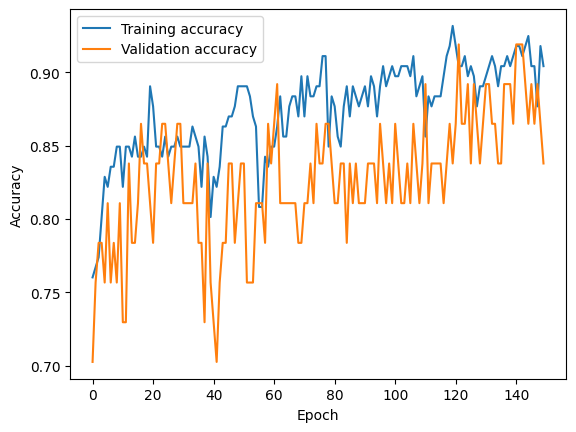

In [15]:
overfitting_dropout_model = TitanicModelHugeOverfittingDropout()
tr3, te3 = train_model(overfitting_dropout_model)

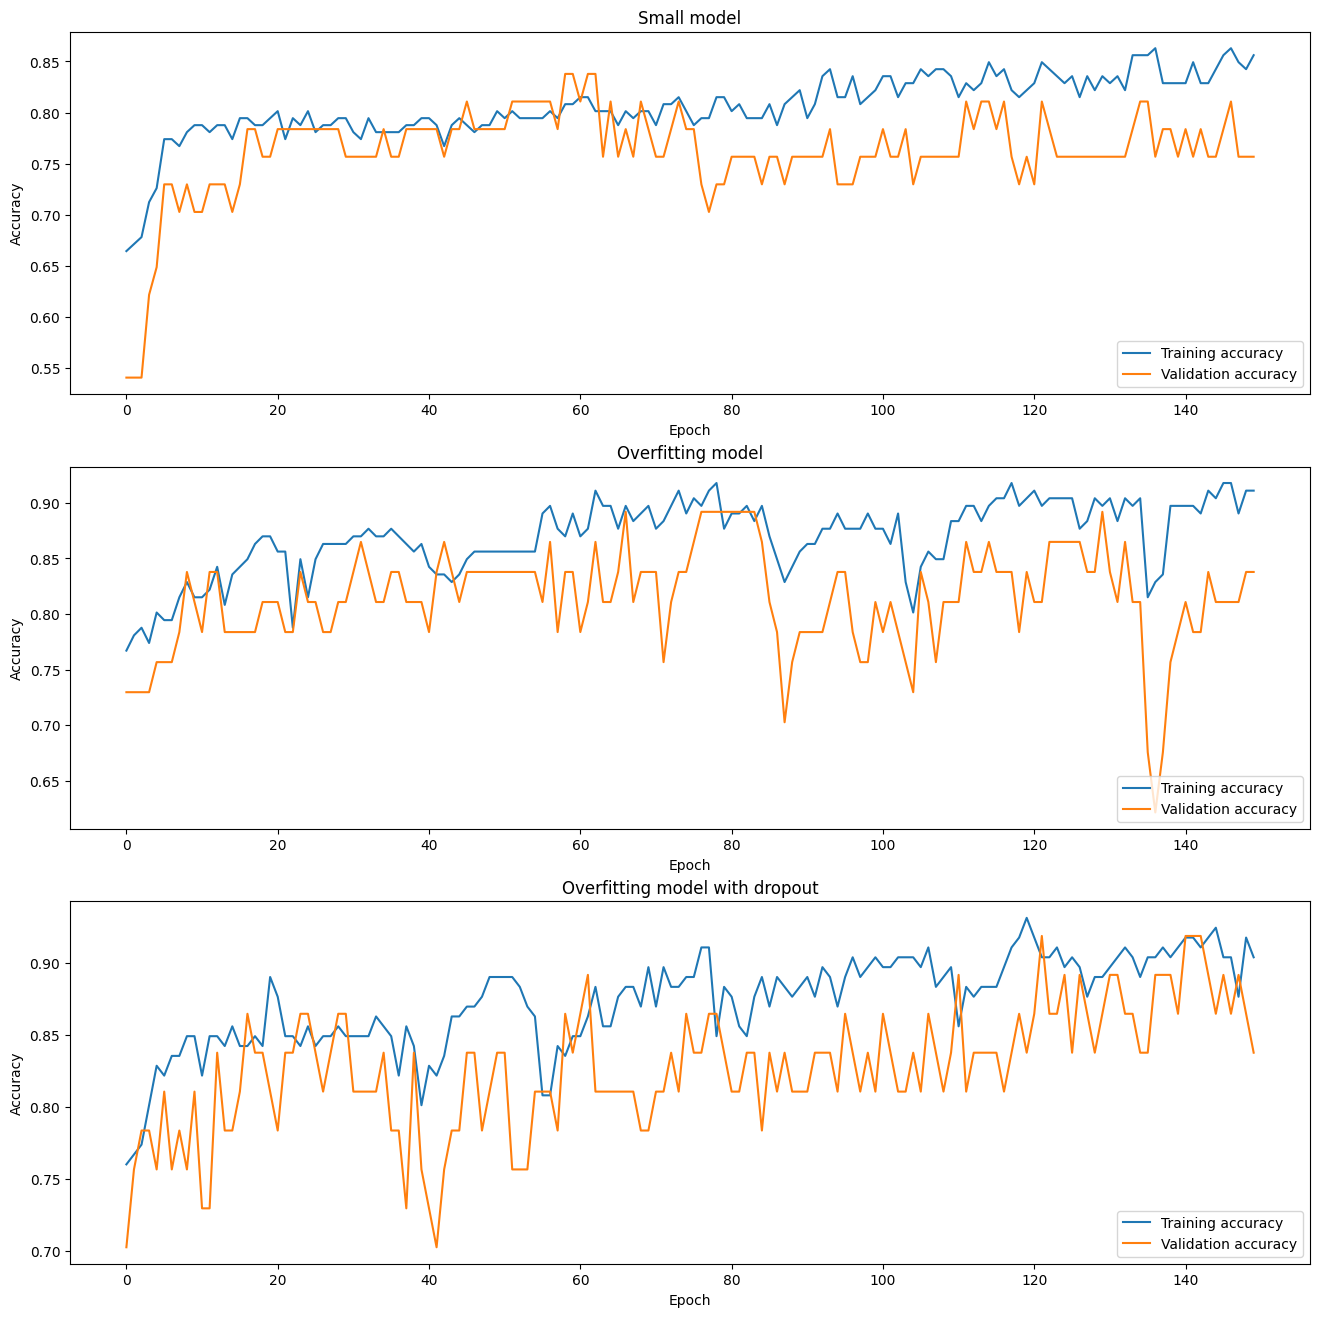

In [16]:
LEGEND_LOCATION = 'lower right'
plt.figure(figsize=(16, 16))
plt.subplot(311)
plt.title('Small model')
plot_accuracy_array(tr1, 'Training accuracy')
plot_accuracy_array(te1, 'Validation accuracy')
plt.legend(loc=LEGEND_LOCATION)
plt.subplot(312)
plt.title('Overfitting model')
plot_accuracy_array(tr2, 'Training accuracy')
plot_accuracy_array(te2, 'Validation accuracy')
plt.legend(loc=LEGEND_LOCATION)
plt.subplot(313)
plt.title('Overfitting model with dropout')
plot_accuracy_array(tr3, 'Training accuracy')
plot_accuracy_array(te3, 'Validation accuracy')
# Legend on bottom left
plt.legend(loc=LEGEND_LOCATION)
plt.show()